<a href="https://colab.research.google.com/github/SiyuFang/STAT6289/blob/master/demo%20presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective


Demonstrate how to generate text using a character-based RNN


*   Given a sequence of characters from this data ("Shakespear"), train a model to predict the next character in the sequence ("e"). 
*   Longer sequences of text can be generated by calling the model repeatedly.

# Dataset

Import TensorFlow and other libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

Download the Shakespeare dataset

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

lenth of the text of the dataset

In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


unique characters

In [4]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

65 unique characters


first 250 charaters

In [5]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



# Process the text

## Vectorize the text

Before training, you need to map strings to a numerical representation. Create two lookup tables: one mapping characters to numbers, and another for numbers to characters

In [6]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

Now we have an integer representation for each character. We mapped the character as indexes from 0 to len(unique).

In [7]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [8]:
# Show how the first 13 characters from the text are mapped to integers
print('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'First Citizen' ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


# Create training examples and targets

Divide the text into example sequences 
*   Input sequence:contain seq_length characters from the text
*   Target: seq_length+1
*   For example, say seq_length is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".






Firstly, use the tf.data.Dataset.from_tensor_slices function to convert the text vector into a stream of character indices.

In [9]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

F
i
r
s
t


Secondly, the batch method lets us easily convert these individual characters to sequences of the desired size.


In [10]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For each sequence, duplicate and shift it to form the input and target text by using the map method to apply a simple function to each batch:

In [11]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

Print the first example input and target values:

In [12]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Each index of these vectors is processed as a one time step. For the input at time step 0, the model receives the index for "F" and tries to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [13]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 18 ('F')
  expected output: 47 ('i')
Step    1
  input: 47 ('i')
  expected output: 56 ('r')
Step    2
  input: 56 ('r')
  expected output: 57 ('s')
Step    3
  input: 57 ('s')
  expected output: 58 ('t')
Step    4
  input: 58 ('t')
  expected output: 1 (' ')


## Create training batches

In [14]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

# Build The Model

Use tf.keras.Sequential to define the model. For this simple example three layers are used to define our model:
tf.keras.layers.Embedding: The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;
tf.keras.layers.GRU: A type of RNN with size units=rnn_units (You can also use an LSTM layer here.)
tf.keras.layers.Dense: The output layer, with vocab_size outputs.

In [15]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [16]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [17]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:
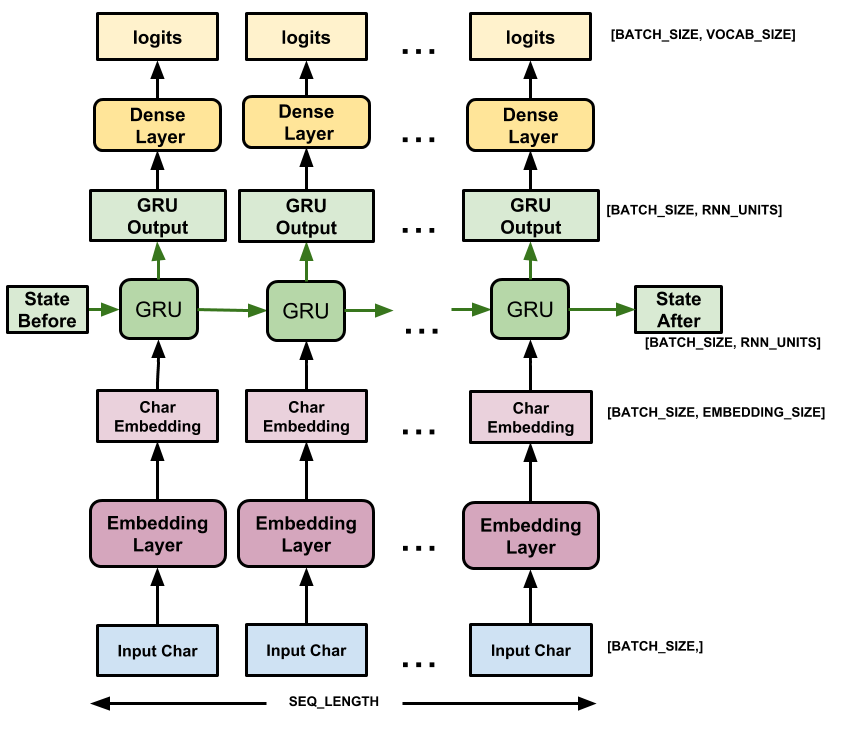

# Try the model

First check the shape of the output:

In [18]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is 100 but the model can be run on inputs of any length:

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


Try it for the first example in the batch:

In [20]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

a prediction of the next character index:

In [21]:
sampled_indices

array([26, 13, 13, 60,  0, 10, 23,  1, 28, 31,  5, 40, 41,  1, 34, 21, 50,
        6,  8, 17, 32, 50, 34, 41, 44, 52,  7, 17, 52,  8, 28, 24, 26,  2,
       49,  1,  9, 32, 51, 33, 15, 56, 40, 53, 36, 36,  0, 19, 43, 27, 16,
       25, 43, 59, 48, 63, 55, 15,  0, 44,  0, 23, 46, 64,  2, 29, 21, 34,
        6, 54, 38, 38, 61, 35, 10,  6, 36, 43, 64, 18, 27,  2,  7, 29, 57,
       30,  6, 47, 39,  6, 39, 18, 59, 33,  8, 36, 43, 19, 31, 52])

Decode these to see the text predicted by this untrained model:

In [22]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'ET:\nHow camest thou hither, tell me, and wherefore?\nThe orchard walls are high and hard to climb,\nAn'

Next Char Predictions: 
 "NAAv\n:K PS'bc VIl,.ETlVcfn-En.PLN!k 3TmUCrboXX\nGeODMeujyqC\nf\nKhz!QIV,pZZwW:,XezFO!-QsR,ia,aFuU.XeGSn"


# Train the model

## Attach an optimizer, and a loss function
The standard tf.keras.losses.sparse_categorical_crossentropy loss function works in this case because it is applied across the last dimension of the predictions.
Because your model returns logits, you need to set the from_logits flag.

In [23]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.174599


Configure the training procedure using the tf.keras.Model.compile method. Use tf.keras.optimizers.Adam with default arguments and the loss function.

In [24]:
model.compile(optimizer='adam', loss=loss)

## Configure checkpoints

Use a tf.keras.callbacks.ModelCheckpoint to ensure that checkpoints are saved during training:

In [25]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

## Execute the training

In [26]:
EPOCHS = 10

In [27]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 10s 57ms/step - loss: 2.6482
Epoch 2/10
172/172 [==============================] - 10s 59ms/step - loss: 1.9501
Epoch 3/10
172/172 [==============================] - 10s 59ms/step - loss: 1.6854
Epoch 4/10
172/172 [==============================] - 10s 61ms/step - loss: 1.5393
Epoch 5/10
172/172 [==============================] - 10s 60ms/step - loss: 1.4520
Epoch 6/10
172/172 [==============================] - 10s 58ms/step - loss: 1.3927
Epoch 7/10
172/172 [==============================] - 10s 58ms/step - loss: 1.3470
Epoch 8/10
172/172 [==============================] - 10s 58ms/step - loss: 1.3089
Epoch 9/10
172/172 [==============================] - 10s 58ms/step - loss: 1.2736
Epoch 10/10
172/172 [==============================] - 10s 58ms/step - loss: 1.2399


In [28]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

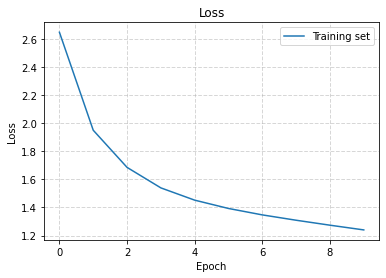

In [29]:
render_training_history(history)

# Generate text

## Restore the latest checkpoint
To keep this prediction step simple, use a batch size of 1.
Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.
To run the model with a different batch_size, you need to rebuild the model and restore the weights from the checkpoint.

In [30]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_10'

In [31]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

* Begin by choosing a start string, initializing the RNN state and setting the number of characters to generate.

* Get the prediction distribution of the next character using the start string and the RNN state.

* Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

* The RNN state returned by the model is fed back into the model so that it now has more context, instead of only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

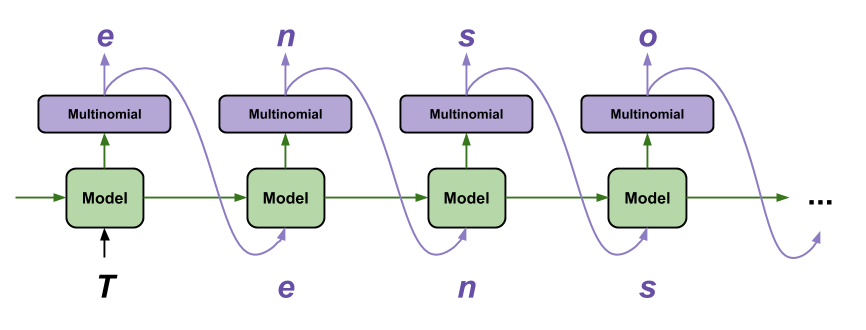


Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [33]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [34]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: disposant granted too;
But if I bear of this thirty voices,
It a did upon my house.
Fear not, seek me let in a hunation of my brother's sake.
She, eart's dest thine my queen and that chance to attending stone
Did ever resisted remains;
And neither weak and sensis or sweet spire.

CURT:
If there'e tale-taites. Strange as a fool, of wares,
Go plant ununses arts,
With this will I wept to the purpose. Bescenderou,
God like the duke and nong but one sword
think it with dearested and dinner
meet with us.

ANGELO:
Deep dievermation
Than fall to hasty the return, and your cat to

ANGELO:
He doth offend my adverse tasses
I may not see my war. I see thy face
Before forwithalight; that I am nom so; bring the
pray, and sthat doth not have a gun
Of all thy peault can learn our killers.
Though I pass most warr'd good with thy
speech sweet tride, or else has needs,
We heard most strangel blows.

Volsce:
What, an oaths
Have metains once goeat against Thy name affright:
A man thou with a merry r

# Conclusion

While some of the sentences are grammatical, most do not make sense. The model has not learned the meaning of words, but consider:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text.

* The structure of the output resembles a play—blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* As demonstrated below, the model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.




Improve the result
*   Increase Epochs (eg: increase epochs=50)
*   Different start string
*   Add another RNN layer to imporve the model's accuracy
*   Adjust the temperature parameter to generate more or less random predictions.





For example: Epochs=50

In [39]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [40]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.174599


In [41]:
model.compile(optimizer='adam', loss=loss)

In [42]:
EPOCHS=50


In [43]:
history1 = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/50
172/172 [==============================] - 10s 57ms/step - loss: 2.6955
Epoch 2/50
172/172 [==============================] - 10s 58ms/step - loss: 1.9619
Epoch 3/50
172/172 [==============================] - 10s 59ms/step - loss: 1.6955
Epoch 4/50
172/172 [==============================] - 10s 60ms/step - loss: 1.5457
Epoch 5/50
172/172 [==============================] - 10s 60ms/step - loss: 1.4586
Epoch 6/50
172/172 [==============================] - 10s 58ms/step - loss: 1.3977
Epoch 7/50
172/172 [==============================] - 10s 58ms/step - loss: 1.3522
Epoch 8/50
172/172 [==============================] - 10s 57ms/step - loss: 1.3136
Epoch 9/50
172/172 [==============================] - 10s 58ms/step - loss: 1.2783
Epoch 10/50
172/172 [==============================] - 10s 58ms/step - loss: 1.2464
Epoch 11/50
172/172 [==============================] - 10s 58ms/step - loss: 1.2143
Epoch 12/50
172/172 [==============================] - 10s 59ms/step - loss: 1.1815
E

In [44]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

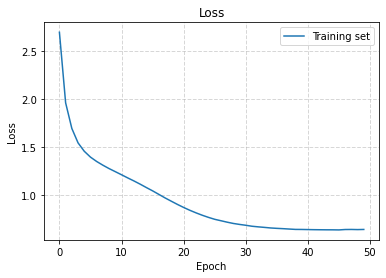

In [45]:
render_training_history(history1)

In [46]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_50'

In [47]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_3 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_3 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [51]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [52]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: I commanded,
Nothing but to instruct herself.

WARWICK:
Speak breathe the merry!

SAMPSON:
Therefore I tear thee? Jan: get to cut off,
Call it not patience, Grumio?

GRUMIO:
Nay, I will warm from yourselves word betwitch'd; stumbled.

Nurse:
It may, my liege, I come you and yours,
That thou commest daughter, and Marcius Angelo
That he good day,
Not all too little from the maim at our office
The second name, tire done to Friar Lodow here: the heads of France,
Have I since your humble swain, and can yield him.
I shortl me! what was yourself we had lived.
Dost thou dete
As you have but twenty-flow'd but seeks; he had not
Jonnor that thy wisdom be repented:
Now swore in happing ntions and my drows are dead.

LORD BERKINGHAM:
Who hath a white assistin Ander wash'd to down.
Paint; I said 'what tears with trees:
For this we have advertis better there,
I then crave him to my royal hand:
By mine honour, thou the ig-ord rejed?

GLOUCESTER:
You may deny this ain. Fear not the king,
My hang

# Source

https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_generation.ipynb